Analizando I_E = 10...
Puntos fijos encontrados: 1
  Punto 1: μ_E = 1.289, μ_I = 2.350

Analizando I_E = 13...
Puntos fijos encontrados: 3
  Punto 1: μ_E = 1.342, μ_I = 3.050
  Punto 2: μ_E = 5.028, μ_I = 49.542
  Punto 3: μ_E = 2.237, μ_I = 27.183


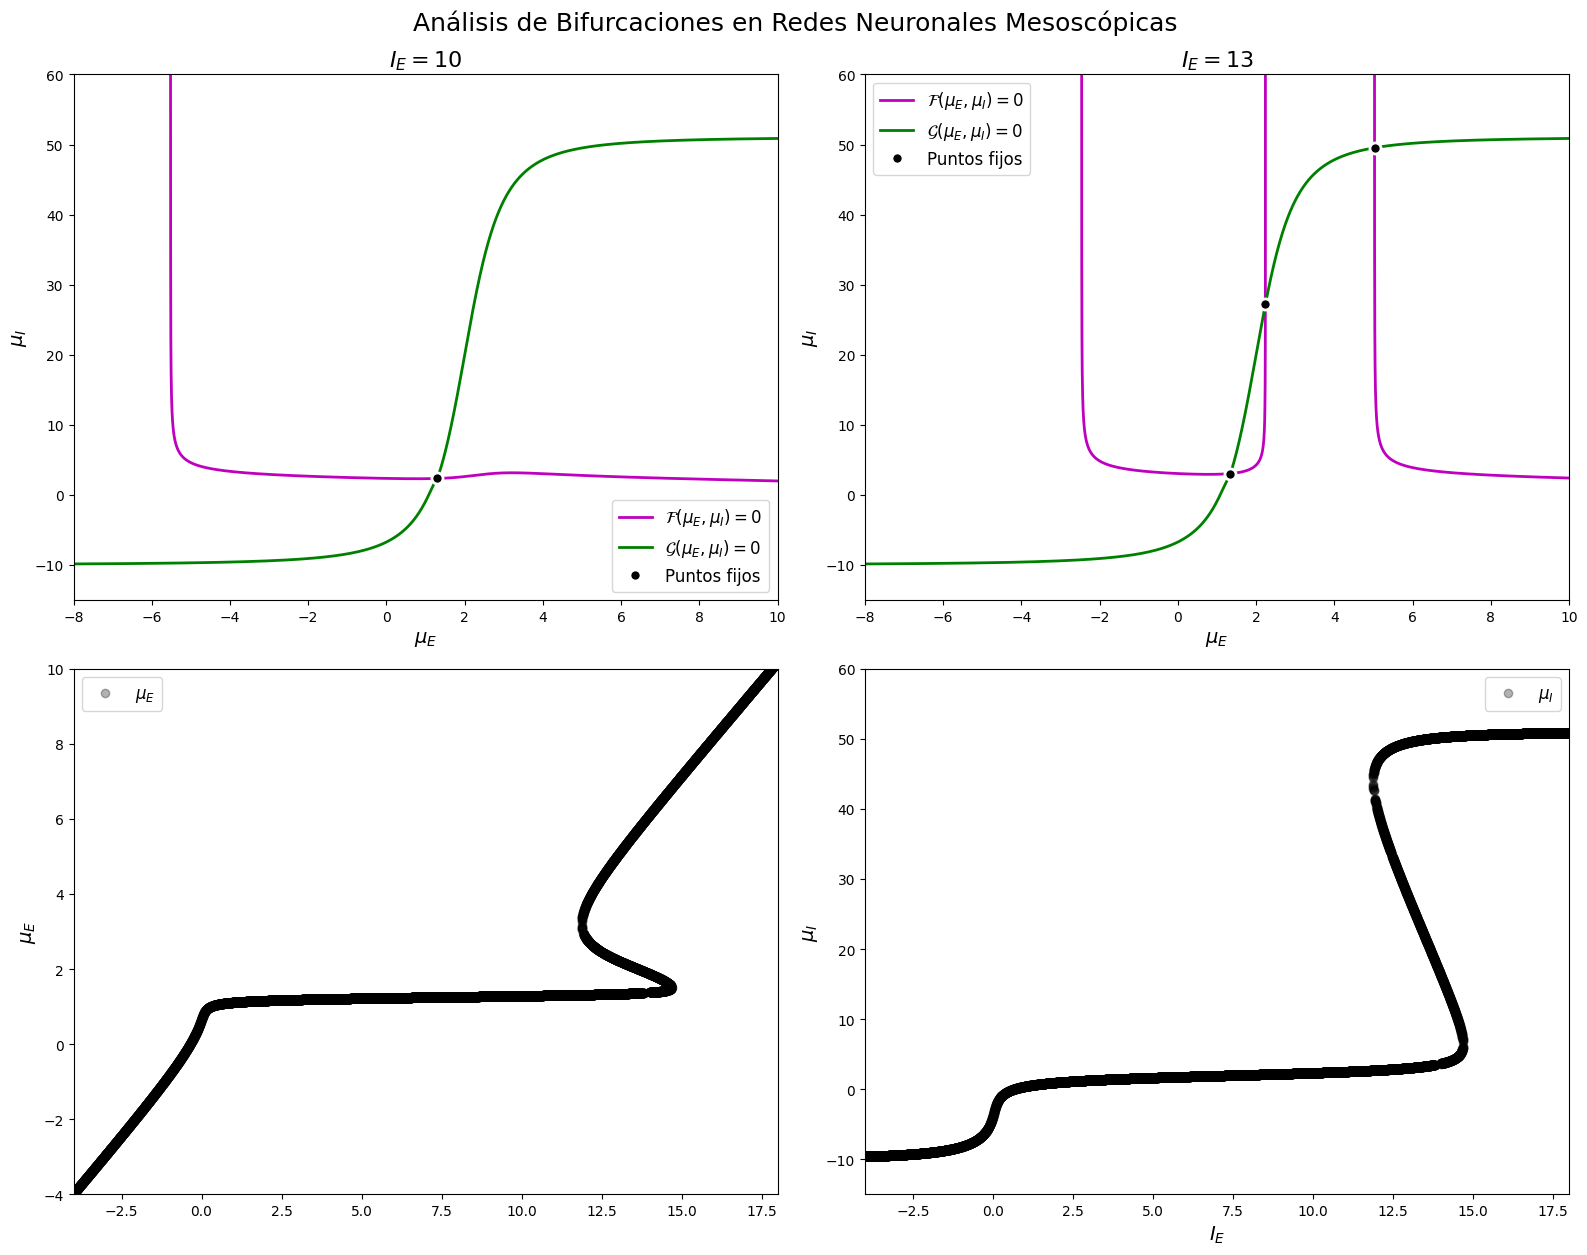

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

class MesoscopicNeuralNetwork:
    def __init__(self, J_II=-10, I_E= 10, I_I = -10):
        # Parámetros del modelo (basados en el paper)
        self.N_E = 8  # Poblaciones excitatorias
        self.N_I = 2  # Poblaciones inhibitorias
        self.N = self.N_E + self.N_I

        # Constantes de tiempo
        self.tau_E = 1
        self.tau_I = 1

        # Pesos sinápticos
        self.J_EE = 10
        self.J_EI = -70  # Inhibitorio
        self.J_IE = 70
        self.J_II = J_II # Inhibitorio, parametro de bifurcacion

        # Parámetros de activación
        self.nu_max_E = 1
        self.nu_max_I = 1
        self.Lambda_E = 2
        self.Lambda_I = 2
        self.V_t_E = 2
        self.V_t_I = 2

        # Entrada externa
        self.I_E = I_E  #Parametro de bifurcation
        self.I_I = I_I #Parametro de bifurcation

    def activation_function(self, V, nu_max, Lambda, V_t):
        """Función de activación algebraica suave"""
        x = V - V_t
        return (nu_max/2) * (1 + (Lambda/2) * x / np.sqrt(1 + (Lambda**2/4) * x**2))

    def F(self, mu_E, mu_I):
        """Nullcline para población excitatoria"""
        A_E = self.activation_function(mu_E, self.nu_max_E, self.Lambda_E, self.V_t_E)
        A_I = self.activation_function(mu_I, self.nu_max_I, self.Lambda_I, self.V_t_I)

        return (-mu_E/self.tau_E +
                (self.N_E - 1)/(self.N - 1) * self.J_EE * A_E +
                self.N_I/(self.N - 1) * self.J_EI * A_I +
                self.I_E)

    def G(self, mu_E, mu_I):
        """Nullcline para población inhibitoria"""
        A_E = self.activation_function(mu_E, self.nu_max_E, self.Lambda_E, self.V_t_E)
        A_I = self.activation_function(mu_I, self.nu_max_I, self.Lambda_I, self.V_t_I)

        return (-mu_I/self.tau_I +
                self.N_E/(self.N - 1) * self.J_IE * A_E +
                (self.N_I - 1)/(self.N - 1) * self.J_II * A_I +
                self.I_I)

    def find_fixed_points(self):
        """Encuentra puntos fijos del sistema"""
        def system(vars):
            mu_E, mu_I = vars
            return [self.F(mu_E, mu_I), self.G(mu_E, mu_I)]

        # Múltiples condiciones iniciales para encontrar diferentes puntos fijos
        initial_guesses = [
            [0, 0], [5.7, 40], [-10, -10], [20, -5], [-5.8, 40]
        ]

        fixed_points = []
        for guess in initial_guesses:
            try:
                sol = fsolve(system, guess, xtol=1e-12)
                # Verificar que es realmente una solución
                if np.allclose(system(sol), [0, 0], atol=1e-6):
                    # Evitar duplicados
                    is_duplicate = False
                    for fp in fixed_points:
                        if np.allclose(sol, fp, atol=1e-3):
                            is_duplicate = True
                            break
                    if not is_duplicate:
                        fixed_points.append(sol)
            except:
                continue

        return np.array(fixed_points)

    def plot_nullclines_and_fixed_points(self, I_E_value, ax=None):
        """Grafica nullclines y puntos fijos para un valor dado de I_E"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))

        # Actualizar parámetro
        self.I_E = I_E_value

        # Rango para las gráficas
        muE_range = np.linspace(-8, 10, 10000)
        muI_range = np.linspace(-15, 60, 10000)

        # Calcular nullclines
        F_values = []
        G_values = []

        for mu_E in muE_range:
            # Para nullcline E: encontrar mu_I tal que F_E(mu_E, mu_I) = 0
            def eq_E(mu_I):
                return self.F(mu_E, mu_I[0])

            try:
                mu_I_sol = fsolve(eq_E, [0], xtol=1e-8, maxfev=1000,)[0]
                # Verificar que la solución es válida
                if abs(self.F(mu_E, mu_I_sol)) < 1e-6:
                    F_values.append([mu_E, mu_I_sol])
            except:
                pass

        for mu_I in muI_range:
            # Para nullcline I: encontrar mu_E tal que F_I(mu_E, mu_I) = 0
            def eq_I(mu_E):
                return self.G(mu_E[0], mu_I)

            try:
                mu_E_sol = fsolve(eq_I, [0], xtol=1e-10)[0]
                if abs(self.G(mu_E_sol, mu_I)) < 1e-6:
                    G_values.append([mu_E_sol, mu_I])
            except:
                pass

        # Convertir a arrays
        if F_values:
            F = np.array(F_values)
            ax.plot(F[:, 0], F[:, 1], 'm-', linewidth=2,
                   label=r'$\mathcal{F}(\mu_E,\mu_I)=0$')

        if G_values:
            G = np.array(G_values)
            ax.plot(G[:, 0], G[:, 1], 'g-', linewidth=2,
                   label=r'$\mathcal{G}(\mu_E,\mu_I)=0$')

        # Encontrar y graficar puntos fijos
        fixed_points = self.find_fixed_points()
        if len(fixed_points) > 0:
            ax.plot(fixed_points[:, 0], fixed_points[:, 1], 'ko',
                   markersize=8, markerfacecolor='black', markeredgecolor='white',
                   markeredgewidth=2, label='Puntos fijos')

        # Configuración de la gráfica
        ax.set_xlabel(r'$\mu_E$', fontsize=14)
        ax.set_ylabel(r'$\mu_I$', fontsize=14)
        ax.set_title(f'$I_E = {I_E_value}$', fontsize=16)
        ax.legend(fontsize=12)
        ax.set_xlim(-8, 10)
        ax.set_ylim(-15, 60)

        return fixed_points

def create_bifurcation_diagram():
    """Crea el diagrama de bifurcación completo"""
    network = MesoscopicNeuralNetwork()
    network_1 = MesoscopicNeuralNetwork(I_E=13)

    # Crear subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    ax1, ax2 = axes[0]
    ax3, ax4 = axes[1]


    # Primer caso: I_E = 10
    print("Analizando I_E = 10...")
    fp1 = network.plot_nullclines_and_fixed_points(10, ax1)
    print(f"Puntos fijos encontrados: {len(fp1)}")
    if len(fp1) > 0:
        for i, fp in enumerate(fp1):
            print(f"  Punto {i+1}: μ_E = {fp[0]:.3f}, μ_I = {fp[1]:.3f}")

    # Segundo caso: I_E = 13
    print("\nAnalizando I_E = 13...")
    fp2 = network_1.plot_nullclines_and_fixed_points(13, ax2)
    print(f"Puntos fijos encontrados: {len(fp2)}")
    if len(fp2) > 0:
        for i, fp in enumerate(fp2):
            print(f"  Punto {i+1}: μ_E = {fp[0]:.3f}, μ_I = {fp[1]:.3f}")

    plt.tight_layout()
    plt.suptitle('Análisis de Bifurcaciones en Redes Neuronales Mesoscópicas',
                 fontsize=18, y=1.02)
    
    IE_vector = np.linspace(-4, 18, 10000)
    all_fixed_points = []

    for i in IE_vector:
        network.I_E = i
        fixed_points = network.find_fixed_points()
        for fp in fixed_points:
            all_fixed_points.append([i,fp[0],fp[1]])

    all_fixed_points = np.array(all_fixed_points)

    
    ax3.scatter(all_fixed_points[:,0], all_fixed_points[:,1], color='black',alpha=0.3, label=r'$\mu_E$')
    ax3.set_ylabel(r'$\mu_E$', fontsize=14)
    ax3.legend(fontsize=12)
    ax3.set_xlim(-4, 18)
    ax3.set_ylim(-4, 10)

    ax4.scatter(all_fixed_points[:,0], all_fixed_points[:,2], color='black',alpha=0.3, label=r'$\mu_I$')
    ax4.set_xlabel(r'$I_E$', fontsize=14)
    ax4.set_ylabel(r'$\mu_I$', fontsize=14)
    ax4.legend(fontsize=12)
    ax4.set_xlim(-4, 18)
    ax4.set_ylim(-15, 60)
    plt.show()

    return fig

# Ejecutar análisis
if __name__ == "__main__":
    # Crear diagrama principal
    fig = create_bifurcation_diagram()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import warnings
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Ignorar advertencias de fsolve para mantener la salida limpia
warnings.filterwarnings('ignore', 'The iteration is not making good progress')

class StrongInhibitionNetwork:
    """
    Modela una red neuronal mesoscópica en el régimen de inhibición fuerte.
    Esto permite la ruptura espontánea de la simetría en la población inhibidora.
    """
    def __init__(self, J_II=-100, I_E=5.0, I_I=-10.0):
        # Parámetros del modelo basados en la Tabla 1 del paper
        self.N_E = 8
        self.N_I = 2
        self.N = self.N_E + self.N_I
        self.tau_E = 1.0
        self.tau_I = 1.0
        self.J_EE = 10.0
        self.J_EI = -70.0
        self.J_IE = 70.0
        self.nu_max_E = 1.0
        self.nu_max_I = 1.0
        self.Lambda_E = 2.0
        self.Lambda_I = 2.0
        self.V_t_E = 2.0
        self.V_t_I = 2.0

        # Parámetros de bifurcación
        self.J_II = J_II
        self.I_E = I_E
        self.I_I = I_I

    def activation_function(self, V, nu_max, Lambda, V_t):
        """Función de activación sigmoidal (Eq. 2)"""
        x = V - V_t
        denominator = np.sqrt(1 + (Lambda**2 / 4) * x**2)
        # Prevenir división por cero si es necesario
        if isinstance(denominator, np.ndarray):
            denominator[denominator == 0] = 1e-9
        elif denominator == 0:
            denominator = 1e-9
        return (nu_max / 2) * (1 + (Lambda / 2) * x / denominator)

    def get_system_equations(self, vars):
        """Define el sistema de 3 ecuaciones no lineales (Eq. 12)"""
        mu_E, mu_I0, mu_I1 = vars

        sl_E = self.activation_function(mu_E, self.nu_max_E, self.Lambda_E, self.V_t_E)
        sl_I0 = self.activation_function(mu_I0, self.nu_max_I, self.Lambda_I, self.V_t_I)
        sl_I1 = self.activation_function(mu_I1, self.nu_max_I, self.Lambda_I, self.V_t_I)

        F = (-mu_E / self.tau_E +
             (self.N_E - 1) / (self.N - 1) * self.J_EE * sl_E +
             self.J_EI / (self.N - 1) * (sl_I0 + sl_I1) + self.I_E)

        G = (-mu_I0 / self.tau_I +
             self.N_E / (self.N - 1) * self.J_IE * sl_E +
             self.J_II / (self.N - 1) * sl_I1 + self.I_I)

        H = (-mu_I1 / self.tau_I +
             self.N_E / (self.N - 1) * self.J_IE * sl_E +
             self.J_II / (self.N - 1) * sl_I0 + self.I_I)

        return [F, G, H]

    def find_fixed_points(self):
        """Encuentra los puntos fijos usando múltiples puntos de partida."""
        # Puntos iniciales para encontrar todas las ramas de soluciones
        initial_guesses = [
            # Rama primaria (simétrica)
            [1.5, 1.5, 1.5], [0, 0, 0], [3, 30, 30],
            # Ramas secundarias (asimétricas)
            [1.5, 1.5, -1], [1.5, -1, 1.5], [1, -2, 4], [1, 4, -2],
            [1.8, 10, -2], [1.8, -2, 10], [1.2, -3, 3]
        ]

        fixed_points = []
        for guess in initial_guesses:
            try:
                sol = fsolve(self.get_system_equations, guess, xtol=1e-9)
                # Verificar si es una solución válida
                if np.allclose(self.get_system_equations(sol), [0, 0, 0], atol=1e-5):
                    # Evitar duplicados
                    is_duplicate = any(np.allclose(sol, fp, atol=1e-3) for fp in fixed_points)
                    if not is_duplicate:
                        fixed_points.append(sol)
            except:
                continue
        return np.array(fixed_points)

def plot_bifurcation_diagrams(ax_E, ax_I):
    """Calcula y grafica los diagramas de bifurcación (paneles inferiores de Fig. 4)"""
    print("Calculando diagrama de bifurcación (puede tardar unos minutos)...")
    network = StrongInhibitionNetwork()
    IE_range = np.linspace(0, 15, 2000)

    primary_branch_E, primary_branch_I = [], []
    secondary_branch_E, secondary_branch_I = [], []

    for ie in IE_range:
        network.I_E = ie
        fixed_points = network.find_fixed_points()
        for fp in fixed_points:
            mu_E, mu_I0, mu_I1 = fp
            # Clasificar en rama primaria (simétrica) o secundaria (asimétrica)
            if np.isclose(mu_I0, mu_I1, atol=1e-2):
                primary_branch_E.append([ie, mu_E])
                primary_branch_I.append([ie, mu_I0])
            else:
                secondary_branch_E.append([ie, mu_E])
                secondary_branch_I.append([ie, mu_I0])
                secondary_branch_I.append([ie, mu_I1])

    # Convertir a arrays y ordenar para graficar
    primary_E = np.array(sorted(primary_branch_E))
    primary_I = np.array(sorted(primary_branch_I))
    secondary_E = np.array(sorted(secondary_branch_E))
    secondary_I = np.array(sorted(secondary_branch_I))

    # Graficar mu_E vs I_E
    ax_E.scatter(primary_E[:, 0], primary_E[:, 1], c='black', s=1, label='Rama Primaria')
    ax_E.scatter(secondary_E[:, 0], secondary_E[:, 1], c='m', s=1, label='Rama Secundaria')
    ax_E.axvline(x=5, color='gray', linestyle='--')
    ax_E.set_ylabel(r'$\mu_E$', fontsize=14)
    ax_E.set_xlim(0, 15)
    ax_E.set_ylim(0, 4)
    ax_E.set_title(r'Diagrama de Bifurcación para $\mu_E$')
    ax_E.legend()

    # Graficar mu_I vs I_E
    ax_I.scatter(primary_I[:, 0], primary_I[:, 1], c='black', s=1)
    ax_I.scatter(secondary_I[:, 0], secondary_I[:, 1], c='m', s=1)
    ax_I.axvline(x=5, color='gray', linestyle='--')
    ax_I.set_xlabel(r'$I_E$', fontsize=14)
    ax_I.set_ylabel(r'$\mu_I$', fontsize=14)
    ax_I.set_xlim(0, 15)
    ax_I.set_ylim(-10, 45)
    ax_I.set_title(r'Diagrama de Bifurcación para $\mu_I$')
    print("Diagrama de bifurcación calculado.")


def plot_nullsurfaces(ax):
    """Calcula y grafica las nullsurfaces (panel superior de Fig. 4)"""
    print("Calculando nullsurfaces para visualización 3D...")
    network = StrongInhibitionNetwork(I_E=5.0)

    # Definir la malla 3D - Swapping mu_E and mu_I0 ranges
    mu_E_range = np.linspace(-5, 5, 100) # Now this will be the x-axis
    mu_I0_range = np.linspace(-5, 5, 100)  # Now this will be the y-axis
    mu_I1_range = np.linspace(-5, 5, 100) # This remains the z-axis
    E_grid, I0_grid, I1_grid = np.meshgrid(mu_E_range, mu_I0_range, mu_I1_range)


    # Calculate the values of the functions F, G, H on the grid
    # Note that the order of variables in network.get_system_equations is [mu_E, mu_I0, mu_I1]
    # So we need to pass the grid variables in the correct order: [E_grid, I0_grid, I1_grid]
    F_vals, G_vals, H_vals = network.get_system_equations([E_grid, I0_grid, I1_grid])


    # Función para graficar una isosuperficie
    def plot_isosurface(vals, color, alpha=0.5):
        try:
            verts, faces, _, _ = measure.marching_cubes(vals, level=0)
            # Escalar vértices al rango original de los ejes
            # The order of scaling needs to match the meshgrid order: x, y, z
            verts[:, 0] = verts[:, 0] * (mu_E_range[-1] - mu_E_range[0]) / (len(mu_E_range)-1) + mu_E_range[0]
            verts[:, 1] = verts[:, 1] * (mu_I0_range[-1] - mu_I0_range[0]) / (len(mu_I0_range)-1) + mu_I0_range[0]
            verts[:, 2] = verts[:, 2] * (mu_I1_range[-1] - mu_I1_range[0]) / (len(mu_I1_range)-1) + mu_I1_range[0]

            mesh = Poly3DCollection(verts[faces])
            mesh.set_facecolor(color)
            mesh.set_edgecolor('k')
            mesh.set_linewidth(0.1)
            mesh.set_alpha(alpha)
            ax.add_collection3d(mesh)
        except (ValueError, RuntimeError) as e:
            print(f"No se pudo generar la isosuperficie para el color {color}: {e}")

    # Graficar las tres nullsurfaces
    plot_isosurface(F_vals, color='skyblue', alpha=0.2)  # F(x,y,z)=0
    plot_isosurface(G_vals, color='limegreen', alpha=0.2) # G(x,y,z)=0
    plot_isosurface(H_vals, color='orange', alpha=0.2) # H(x,y,z)=0

    # Encontrar y graficar los puntos de intersección
    fp = network.find_fixed_points()
    print(fp)
    for p in fp:
        color = 'k' if np.isclose(p[1], p[2], atol=1e-9) else 'm' # Negro para primario, violeta para secundario
        # Plotting with swapped x and y coordinates to match the meshgrid
        depthshade = False if color == 'k' else True
        ax.scatter(p[0], p[1], p[2], c=color, s=150, depthshade=depthshade, edgecolor='w',alpha=1)


    # Swapping axis labels to match the new orientation
    ax.set_xlabel(r'$x \ (\mu_E)$', fontsize=12)
    ax.set_ylabel(r'$y \ (\mu_{I,0})$', fontsize=12)
    ax.set_zlabel(r'$z \ (\mu_{I,1})$', fontsize=12)
    # Adjust limits if necessary based on the new axis ranges
    ax.set_xlim([-5.2, 5.2])
    ax.set_ylim([-5.2, 5.2])
    ax.set_zlim([-5.2, 5.2])
    ax.view_init(elev=20, azim=-120)
    ax.set_title('Nullsurfaces en Régimen de Inhibición Fuerte ($I_E=5$)', fontsize=14)
    print("Nullsurfaces calculadas.")


if __name__ == "__main__":
    # Crear la figura con 3 subplots como en el paper
    fig = plt.figure(figsize=(14, 12))
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, :], projection='3d')
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    # Generar los gráficos
    plot_nullsurfaces(ax1)
    plot_bifurcation_diagrams(ax2, ax3)

    fig.suptitle('Figura 4: Soluciones Estacionarias en Régimen de Inhibición Fuerte ($J_{II}=-100$)', fontsize=18, y=0.97)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('Figura4.png')
    plt.show()